## Extracting data for Richmond from NARCliM for Anir

In [1]:
import xarray as xr
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
import tempfile
import time

sys.path.append('/home/565/dh4185/mn51-dh4185/repos_collab/dataset_finder/')
from dataset_finder import *

# Set the logging level to WARNING, this will mute INFO and DEBUG messages
import logging
logging.basicConfig(level=logging.WARNING)
# Specifically suppress INFO messages from the 'flox' module
logging.getLogger('flox').setLevel(logging.WARNING)

import warnings 
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

In [2]:
# Dask settings
dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, # This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #< This should use the new behaviour which helps with memory pile up
})
client = Client(n_workers=40, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "62000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 40
Total threads: 40,Total memory: 2.26 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44489,Workers: 40
Dashboard: /proxy/8787/status,Total threads: 40
Started: Just now,Total memory: 2.26 TiB
Comm: tcp://127.0.0.1:45991,Total threads: 1
Dashboard: /proxy/34443/status,Memory: 57.74 GiB
Nanny: tcp://127.0.0.1:41247,


2025-04-03 10:32:36,353 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2025-04-03 10:34:24,904 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2025-04-03 10:35:25,492 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-04-03 10:37:06,773 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-04-03 10:37:46,373 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-04-03 10:38:46,102 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-04-03 10:41:07,192 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-04-03 10:42:33,769 - distributed.utils_perf - WARNING - full garbage collections took

In [6]:
loc_coords = {'Richmond':{'lat':-33.60,
                          'lon':150.78,
                          'height':19}
             }
ssps = {'SSP1-2.6':'ssp126',
        'SSP3-7.0':'ssp370'}

_freq = "ME" # YE

gcms = ['ACCESS-ESM1-5','EC-Earth3-Veg','MPI-ESM1-2-HR','NorESM2-MM','UKESM1-0-LL']
rcms = ["NARCliM2-0-WRF412R3","NARCliM2-0-WRF412R5"]


def _preprocess(ds):
    return ds.sel(lat=loc_coords['Richmond']['lat'],
                  lon=loc_coords['Richmond']['lon'],
                  method = "nearest").chunk({'time':-1})

_ssp = ssps['SSP1-2.6']
# _gcm = gcms[0]
# _rcm = rcms[0]

data_holder = []
gcm_rcm_name = []
bc_method = "QME"
bc_ref = "AGCD"

# Create a pandas date range for annual data
new_time_index = pd.date_range(start="2015-01-01", end="2100-12-31", freq=_freq).astype("datetime64[ns]")



In [5]:
%%time

for _gcm in gcms:
    for _rcm in rcms:
        
        # Start the lap timer
        start_time = time.time()
        
        gcm_rcm_name.append(_gcm+"-"+_rcm)
        print(f"====== Running {gcm_rcm_name[-1]} =======")

        #< Specify datasets
        all_data = get_datasets("ACS_BC", 
                                org = "NSW-Government",
                                gcm = _gcm,
                                rcm = _rcm,
                                # rcm = "NARCliM2-0-WRF412R3",
                                empat = _ssp,
                                bc = bc_method,
                                ref = bc_ref)
        multi_dataset = all_data.select(var = ["tasmax","tasmin"])
        print(multi_dataset)

        #< Load data
        loaded_data = xr.open_mfdataset(multi_dataset.get_files(), parallel = True, preprocess = _preprocess)
        
        #< Resample to annual mean values
        annual_mean = loaded_data.resample(time=freq).mean().assign_coords(time=new_time_index)
        
        # Persist AFTER resampling, to keep a smaller dataset in memory
        annual_mean = annual_mean.persist()

        #< Get tasmax and tasmin and calculate tasmean
        tasmax = annual_mean["tasmaxAdjust"].rename("tasmax")
        tasmin = annual_mean["tasminAdjust"].rename("tasmin")
        tasmean = ((tasmax+tasmin)/2).rename("tasmean")
        
        data_holder.append(xr.merge([tasmax,tasmin,tasmean]))

        print(f"Time taken: {(time.time()- start_time):.2f} seconds")

da_all = xr.concat(data_holder, dim=xr.DataArray(gcm_rcm_name, dims="GCM-RCM"))
da_median = da_all.median('GCM-RCM')

da_median.to_netcdf(f"/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/NARCliM_Richmond_{freq}_mean_temperature_MMM_{_ssp}_{bc_method}-{bc_ref}_2015-2100.nc")

====== Running ACCESS-ESM1-5-NARCliM2-0-WRF412R3 =======
    org             gcm            empat    mdl_run    rcm                  ver    bc    ref     bc_period    timescale
--  --------------  -------------  -------  ---------  -------------------  -----  ----  ------  -----------  -----------
 0  NSW-Government  ACCESS-ESM1-5  ssp126   r6i1p1f1   NARCliM2-0-WRF412R3  v1-r1  QME   AGCDv1  1960-2022    day


NameError: name 'freq' is not defined

## Open netcdf time series

In [6]:
ds126 = xr.open_dataset(f"/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/NARCliM_Richmond_annual_mean_temperature_MMM_ssp126_{bc_method}-{bc_ref}_2015-2100.nc")

In [7]:
ds370 = xr.open_dataset(f"/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/NARCliM_Richmond_annual_mean_temperature_MMM_ssp370_{bc_method}-{bc_ref}_2015-2100.nc")

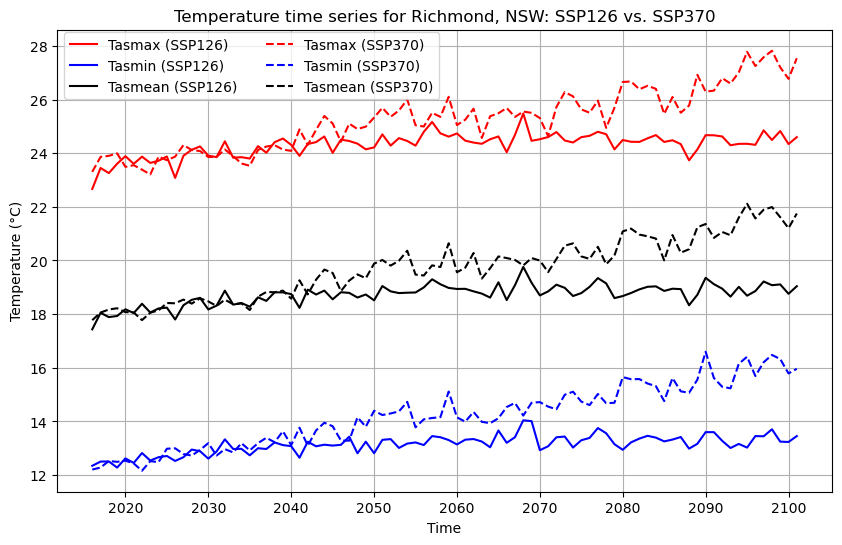

In [15]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot SSP126 (solid lines)
ds126["tasmax"].plot(ax=ax, label="Tasmax (SSP126)", color="red", linestyle="-")
ds126["tasmin"].plot(ax=ax, label="Tasmin (SSP126)", color="blue", linestyle="-")
ds126["tasmean"].plot(ax=ax, label="Tasmean (SSP126)", color="black", linestyle="-")

# Plot SSP370 (dashed lines)
ds370["tasmax"].plot(ax=ax, label="Tasmax (SSP370)", color="red", linestyle="dashed")
ds370["tasmin"].plot(ax=ax, label="Tasmin (SSP370)", color="blue", linestyle="dashed")
ds370["tasmean"].plot(ax=ax, label="Tasmean (SSP370)", color="black", linestyle="dashed")

# Formatting
ax.set_title("Temperature time series for Richmond, NSW: SSP126 vs. SSP370")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Time")
# Adjust legend position and columns
ax.legend(loc="upper left", bbox_to_anchor=(0, 1.01), ncol=2, fontsize=10, frameon=True)
ax.grid(True)

plt.show()

In [8]:
# Rename variables in each dataset to include SSP scenario
ds126 = ds126.rename({
    "tasmax": "tasmax_ssp126",
    "tasmin": "tasmin_ssp126",
    "tasmean": "tasmean_ssp126"
})

ds370 = ds370.rename({
    "tasmax": "tasmax_ssp370",
    "tasmin": "tasmin_ssp370",
    "tasmean": "tasmean_ssp370"
})

# Merge datasets along the time dimension
ds_combined = xr.merge([ds126, ds370])

# Convert to Pandas DataFrame and drop lat/lon if they exist
df_combined = ds_combined.to_dataframe().reset_index()

# Drop lat and lon columns if they exist
df_combined = df_combined.drop(columns=["lat", "lon"], errors="ignore")

# Save to CSV
df_combined.to_csv(f"/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/NARCliM_Richmond_annual_mean_temperature_MMM_ssp126+370_{bc_method}-{bc_ref}_2015-2100.csv", index=False)

print("CSV file saved successfully!")

CSV file saved successfully!


In [7]:
ds126 = xr.open_dataset(f"/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/NARCliM_Richmond_ME_mean_temperature_MMM_ssp126_{bc_method}-{bc_ref}_2015-2100.nc")
ds370 = xr.open_dataset(f"/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/NARCliM_Richmond_ME_mean_temperature_MMM_ssp370_{bc_method}-{bc_ref}_2015-2100.nc")

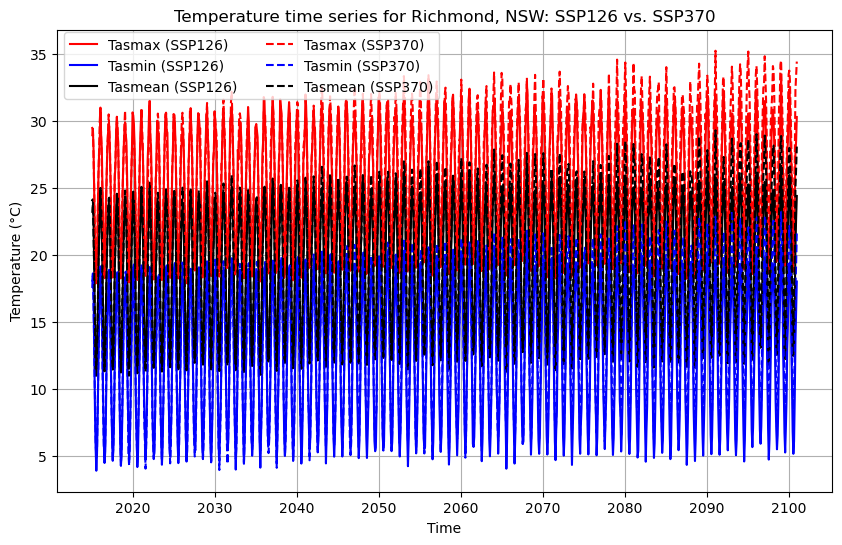

In [8]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot SSP126 (solid lines)
ds126["tasmax"].plot(ax=ax, label="Tasmax (SSP126)", color="red", linestyle="-")
ds126["tasmin"].plot(ax=ax, label="Tasmin (SSP126)", color="blue", linestyle="-")
ds126["tasmean"].plot(ax=ax, label="Tasmean (SSP126)", color="black", linestyle="-")

# Plot SSP370 (dashed lines)
ds370["tasmax"].plot(ax=ax, label="Tasmax (SSP370)", color="red", linestyle="dashed")
ds370["tasmin"].plot(ax=ax, label="Tasmin (SSP370)", color="blue", linestyle="dashed")
ds370["tasmean"].plot(ax=ax, label="Tasmean (SSP370)", color="black", linestyle="dashed")

# Formatting
ax.set_title("Temperature time series for Richmond, NSW: SSP126 vs. SSP370")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Time")
# Adjust legend position and columns
ax.legend(loc="upper left", bbox_to_anchor=(0, 1.01), ncol=2, fontsize=10, frameon=True)
ax.grid(True)

plt.show()

In [9]:
# Rename variables in each dataset to include SSP scenario
ds126 = ds126.rename({
    "tasmax": "tasmax_ssp126",
    "tasmin": "tasmin_ssp126",
    "tasmean": "tasmean_ssp126"
})

ds370 = ds370.rename({
    "tasmax": "tasmax_ssp370",
    "tasmin": "tasmin_ssp370",
    "tasmean": "tasmean_ssp370"
})

# Merge datasets along the time dimension
ds_combined = xr.merge([ds126, ds370])

# Convert to Pandas DataFrame and drop lat/lon if they exist
df_combined = ds_combined.to_dataframe().reset_index()

# Drop lat and lon columns if they exist
df_combined = df_combined.drop(columns=["lat", "lon"], errors="ignore")

# Save to CSV
df_combined.to_csv(f"/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/data/NARCliM_Richmond_monthly_mean_temperature_MMM_ssp126+370_{bc_method}-{bc_ref}_2015-2100.csv", index=False)

print("CSV file saved successfully!")

CSV file saved successfully!
